In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import yaml
import re 
import sys
import xarray as xr 
from pathlib import Path
src_utils_path = Path("../src")
sys.path.append(str(src_utils_path))
import utils.feature_maps as mjo
import utils.WheelerKiladis_util as wk 

In [19]:
exp_dir = "/pscratch/sd/l/linyaoly/MJO_ML_2025/script/model/exp"
exp_names = [
    "CNN_2_FCN_3_hov_sm_to_leads",
]
window_len = 21
residual = 'False'

flg = 'hann'
wgt = True 
fn = '/pscratch/sd/l/linyaoly/MJO_ML_2025/script/model/data/raw/olr.day.noaa.2x2.nc'
ds = xr.open_dataset(fn, engine='netcdf4')

olr = ds['olr'].sel(time=slice('2015-01-01', '2021-12-31'))

if residual == 'True':
    sym_olr_sm, _ = wk.spacetime_power_runningavg_minus(olr, segsize=96, noverlap=60, spd=1, lat_lim=10, remove_low=True, sigtest=False, window_len=window_len, weighted=wgt)
    olr_power_norm = sym_olr_sm / np.sum(sym_olr_sm)
else:
    sym_olr_sm, _ = wk.spacetime_power_runningavg(olr, segsize=96, noverlap=60, spd=1, lat_lim=10, remove_low=True, sigtest=False, window_len=window_len, weighted=wgt)
    olr_power_norm = sym_olr_sm / np.sum(sym_olr_sm)

coordinates:  ('time', 'lat', 'lon', 'segments')
size of x_roll_sym_asym:  (69, 11, 180, 96)


In [20]:
folder_list = [os.path.join(exp_dir, name) for name in exp_names]

power_norms = []

for folder in folder_list:
    # fn = os.path.join(folder, "feature_power_norm_-1_c51.nc")
    fn = os.path.join(folder, f'feature_power_norm_-1_sm{window_len}_res{residual}.nc')
    if not os.path.exists(fn):
        print(f"{fn} not found, skipping.")
        continue

    power = xr.open_dataset(fn)['power_norm']
    power[:,:,0,:] = 0.0
    power_norms.append(power)



/pscratch/sd/l/linyaoly/mlpy/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


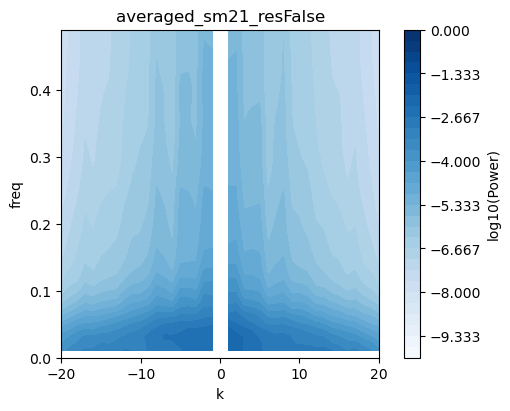

In [21]:
k = np.concatenate([np.fft.fftfreq(180, d=1/180)[-20:], np.fft.fftfreq(180, d=1/180)[:21]], axis=0)
m = np.fft.fftfreq(96)[:48]  # x and y axes
fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)
power_exp1 = np.mean(power_norms[0][0],axis=0)
data = np.concatenate([np.log10(power_exp1)[:48, -20:], np.log10(power_exp1)[:48, :21]], axis=1)  # select first 20 k values
cf = ax.contourf(k, m, data[:,::-1], cmap='Blues',levels=np.linspace(-10,0,31))
ax.set_title(f'averaged_sm{window_len}_res{residual}')
ax.set_xlabel('k')
ax.set_ylabel('freq')

# Add a single colorbar for all subplots
fig.colorbar(cf, ax=ax, label='log10(Power)')

plt.show()

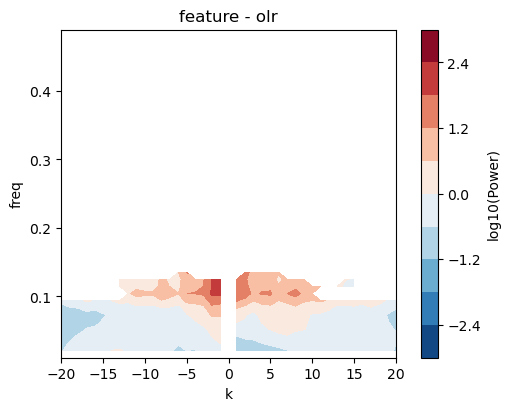

In [22]:
dataolr = olr_power_norm.sel(wavenumber=slice(-20,20))
dataolr = dataolr.where(np.log10(dataolr)>-6)
fig, ax = plt.subplots(1, 1, figsize=(5, 4), constrained_layout=True)

cf = ax.contourf(dataolr.wavenumber, dataolr.frequency, (data[:47,:]- np.log10(dataolr.T)), cmap='RdBu_r',levels=np.linspace(-3,3,11))
ax.set_title(f'feature - olr')
ax.set_xlabel('k')
ax.set_ylabel('freq')

# Add a single colorbar for all subplots
fig.colorbar(cf, ax=ax, label='log10(Power)')

plt.show()

/pscratch/sd/l/linyaoly/mlpy/lib/python3.11/site-packages/xarray/computation/apply_ufunc.py:814: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


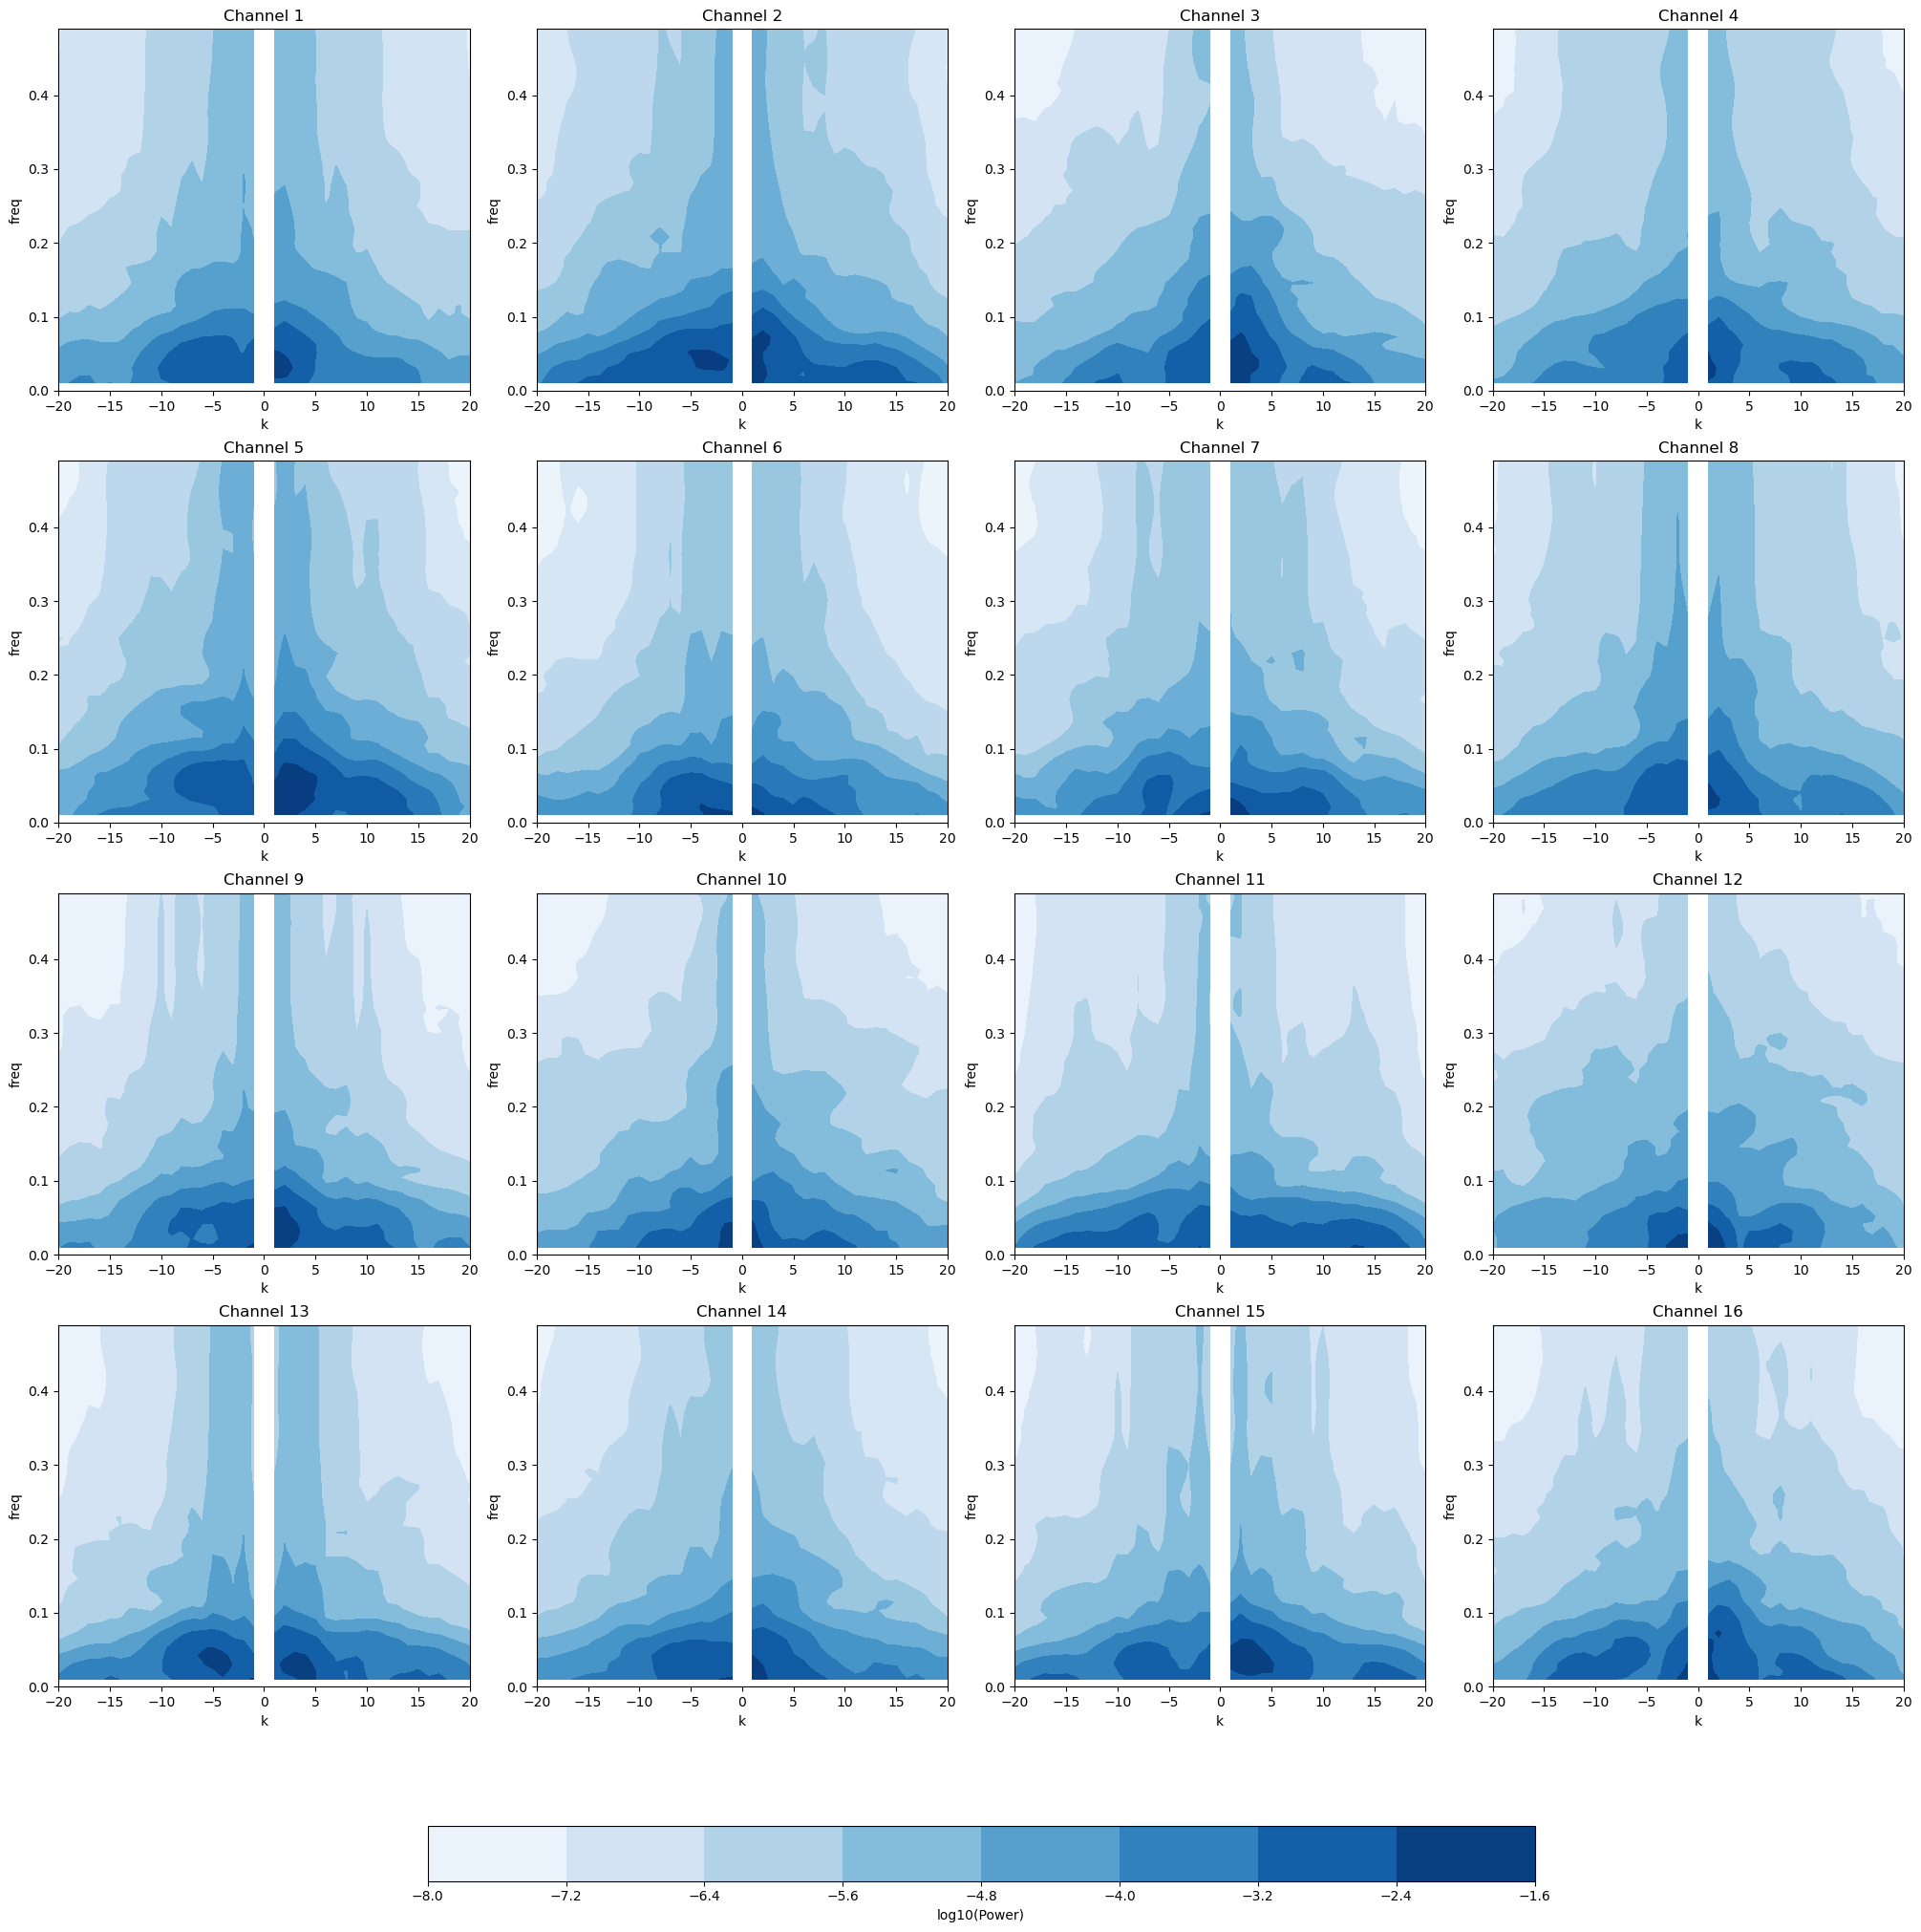

In [25]:
k = np.concatenate([np.fft.fftfreq(180, d=1/180)[-20:], np.fft.fftfreq(180, d=1/180)[:21]], axis=0)
m = np.fft.fftfreq(96)[:48]  # x and y axes
fig, axes = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)
power_exp1 = power_norms[0][0]
for i in range(16):
    ax = axes[i // 4, i % 4]
    data = np.concatenate([np.log10(power_exp1[i])[:48, -20:], np.log10(power_exp1[i])[:48, :21]], axis=1)  # select first 20 k values
    cf = ax.contourf(k, m, data[:,::-1], cmap='Blues')
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('k')
    ax.set_ylabel('freq')

# Add a single colorbar for all subplots
fig.colorbar(cf, ax=axes, orientation='horizontal', shrink=0.6, label='log10(Power)')

plt.show()

In [9]:
exp_dir = "/pscratch/sd/l/linyaoly/MJO_ML_2025/script/model/exp"
exp_names = [
    # "CNN_1_FCN_1_map_to_leads",
    # "CNN_2_FCN_2_map_to_leads",
    # # "CNN_3_FCN_3_map_to_leads",
    "CNN_2_FCN_2_hov_to_leads",
    # "CNN_2_FCN_2_hov_two_to_leads",
    # "CNN_2_FCN_2_latavg_to_leads",
    # # "CNN_2_FCN_2_latavg_time_to_leads",
    # "CNN_2_FCN_2_map_sym_to_leads",
    # "CNN_2_FCN_2_map_asym_to_leads",
]

folder_list = [os.path.join(exp_dir, name) for name in exp_names]

power_norms = []

for folder in folder_list:
    # fn = os.path.join(folder, "feature_power_norm_-1_c51.nc")
    fn = os.path.join(folder, "feature_power_norm_-1.nc")
    if not os.path.exists(fn):
        print(f"{fn} not found, skipping.")
        continue

    power = xr.open_dataset(fn)['power_norm']
    power[:,:,0,:] = 0.0
    power_norms.append(power)



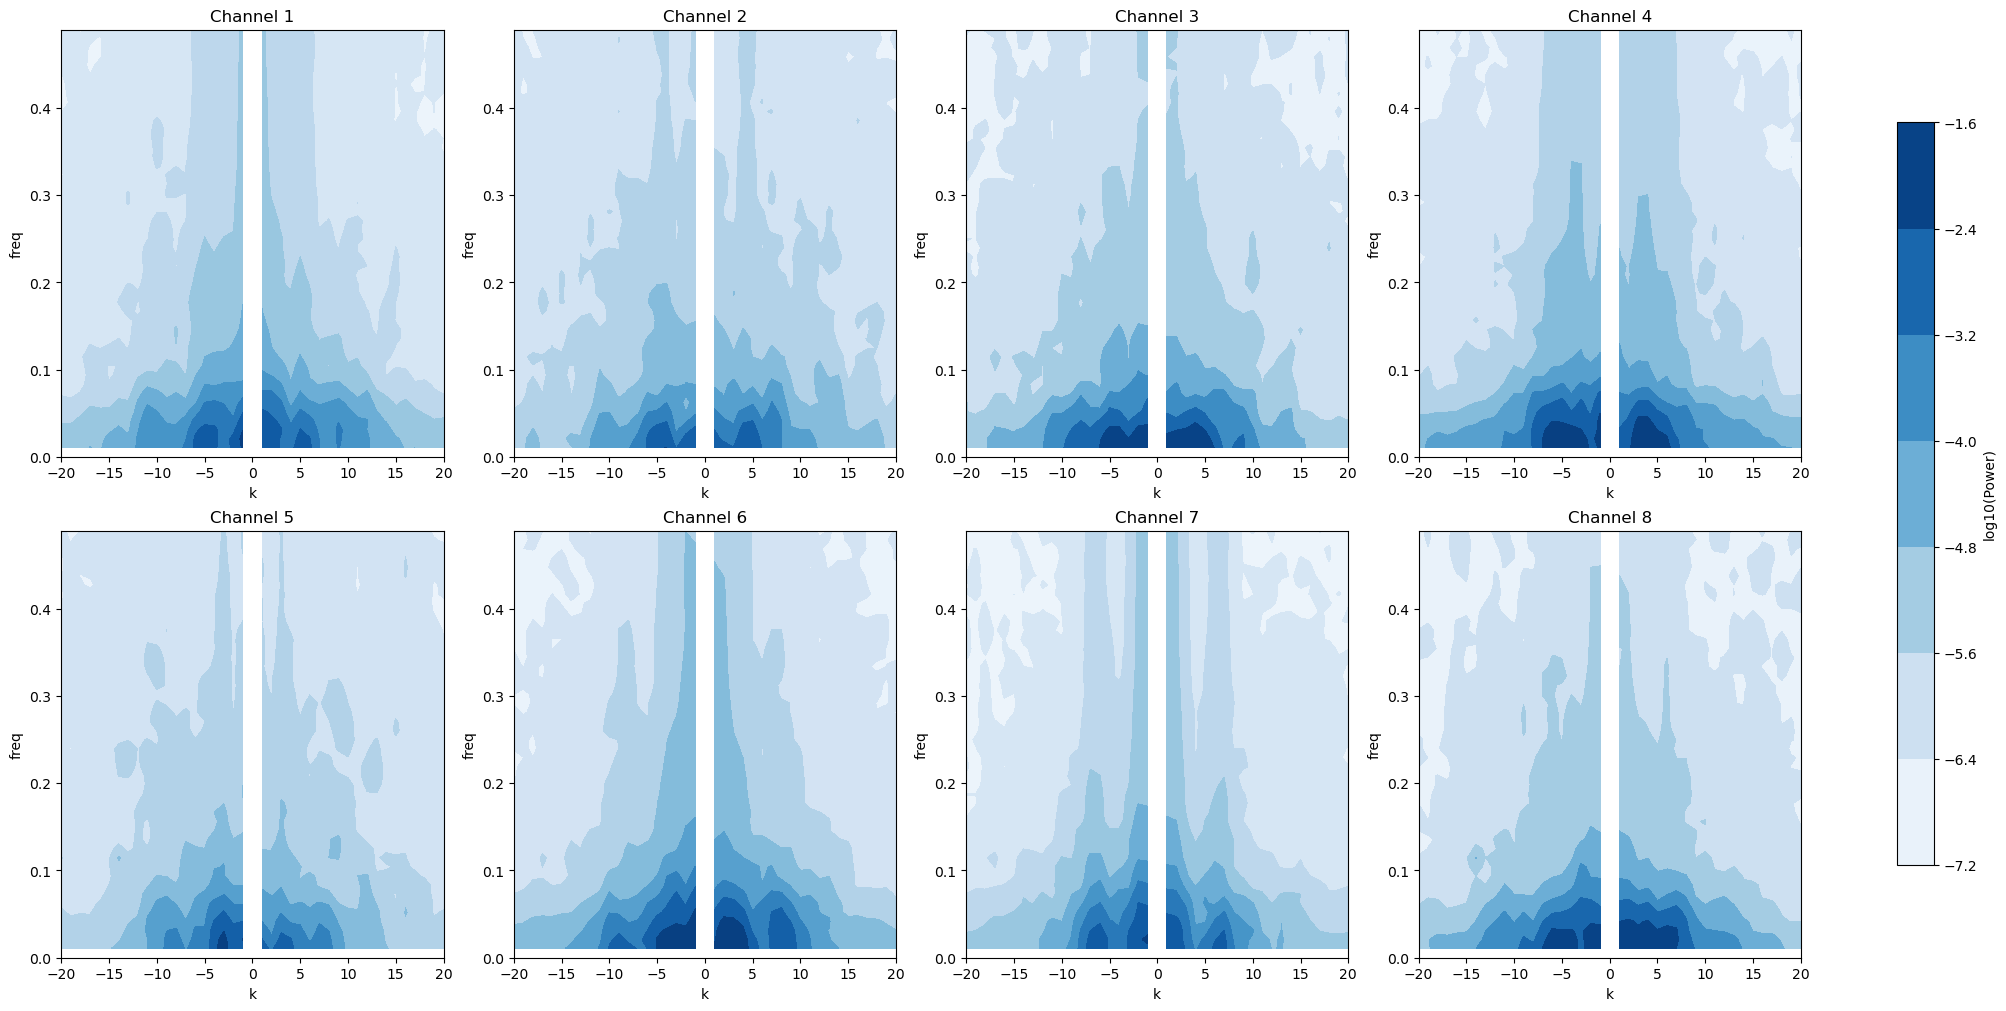

In [19]:

k = np.concatenate([np.fft.fftfreq(180, d=1/180)[-20:], np.fft.fftfreq(180, d=1/180)[:21]], axis=0)
m = np.fft.fftfreq(96)[:48]  # x and y axes
fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)

for i in range(8):
    ax = axes[i // 4, i % 4]
    data = np.concatenate([np.log10(power_exp1[i])[:48, -20:], np.log10(power_exp1[i])[:48, :21]], axis=1)  # select first 20 k values
    cf = ax.contourf(k, m, data, cmap='Blues')
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('k')
    ax.set_ylabel('freq')

# Add a single colorbar for all subplots
fig.colorbar(cf, ax=axes, orientation='vertical', shrink=0.8, label='log10(Power)')

plt.show()

In [2]:
exp_dir = "/pscratch/sd/l/linyaoly/MJO_ML_2025/script/model/exp"
exp_names = [
    # "CNN_1_FCN_1_map_to_leads",
    # "CNN_2_FCN_2_map_to_leads",
    # # "CNN_3_FCN_3_map_to_leads",
    "CNN_2_FCN_2_hov_to_leads",
    # "CNN_2_FCN_2_hov_two_to_leads",
    # "CNN_2_FCN_2_latavg_to_leads",
    # # "CNN_2_FCN_2_latavg_time_to_leads",
    # "CNN_2_FCN_2_map_sym_to_leads",
    # "CNN_2_FCN_2_map_asym_to_leads",
]

folder_list = [os.path.join(exp_dir, name) for name in exp_names]

power_norms = []

for folder in folder_list:
    fn = os.path.join(folder, "kernels_power_norm_cnn.network.3.weight.nc")
    if not os.path.exists(fn):
        print(f"{fn} not found, skipping.")
        continue

    power = xr.open_dataset(fn)['power_norm']
    power_norms.append(power)



In [3]:
power

<xarray.DataArray 'power_norm' (exp_num: 96, filter: 512, ky: 13, kx: 105)>
[67092480 values with dtype=float64]
Coordinates:
  * filter   (filter) int64 0 1 2 3 4 5 6 7 ... 504 505 506 507 508 509 510 511
  * ky       (ky) float64 0.0 0.07692 0.1538 0.2308 ... -0.2308 -0.1538 -0.07692
  * kx       (kx) float64 0.0 0.009524 0.01905 ... -0.02857 -0.01905 -0.009524
Dimensions without coordinates: exp_num
Attributes:
    hidden_layer:  cnn.network.3.weight

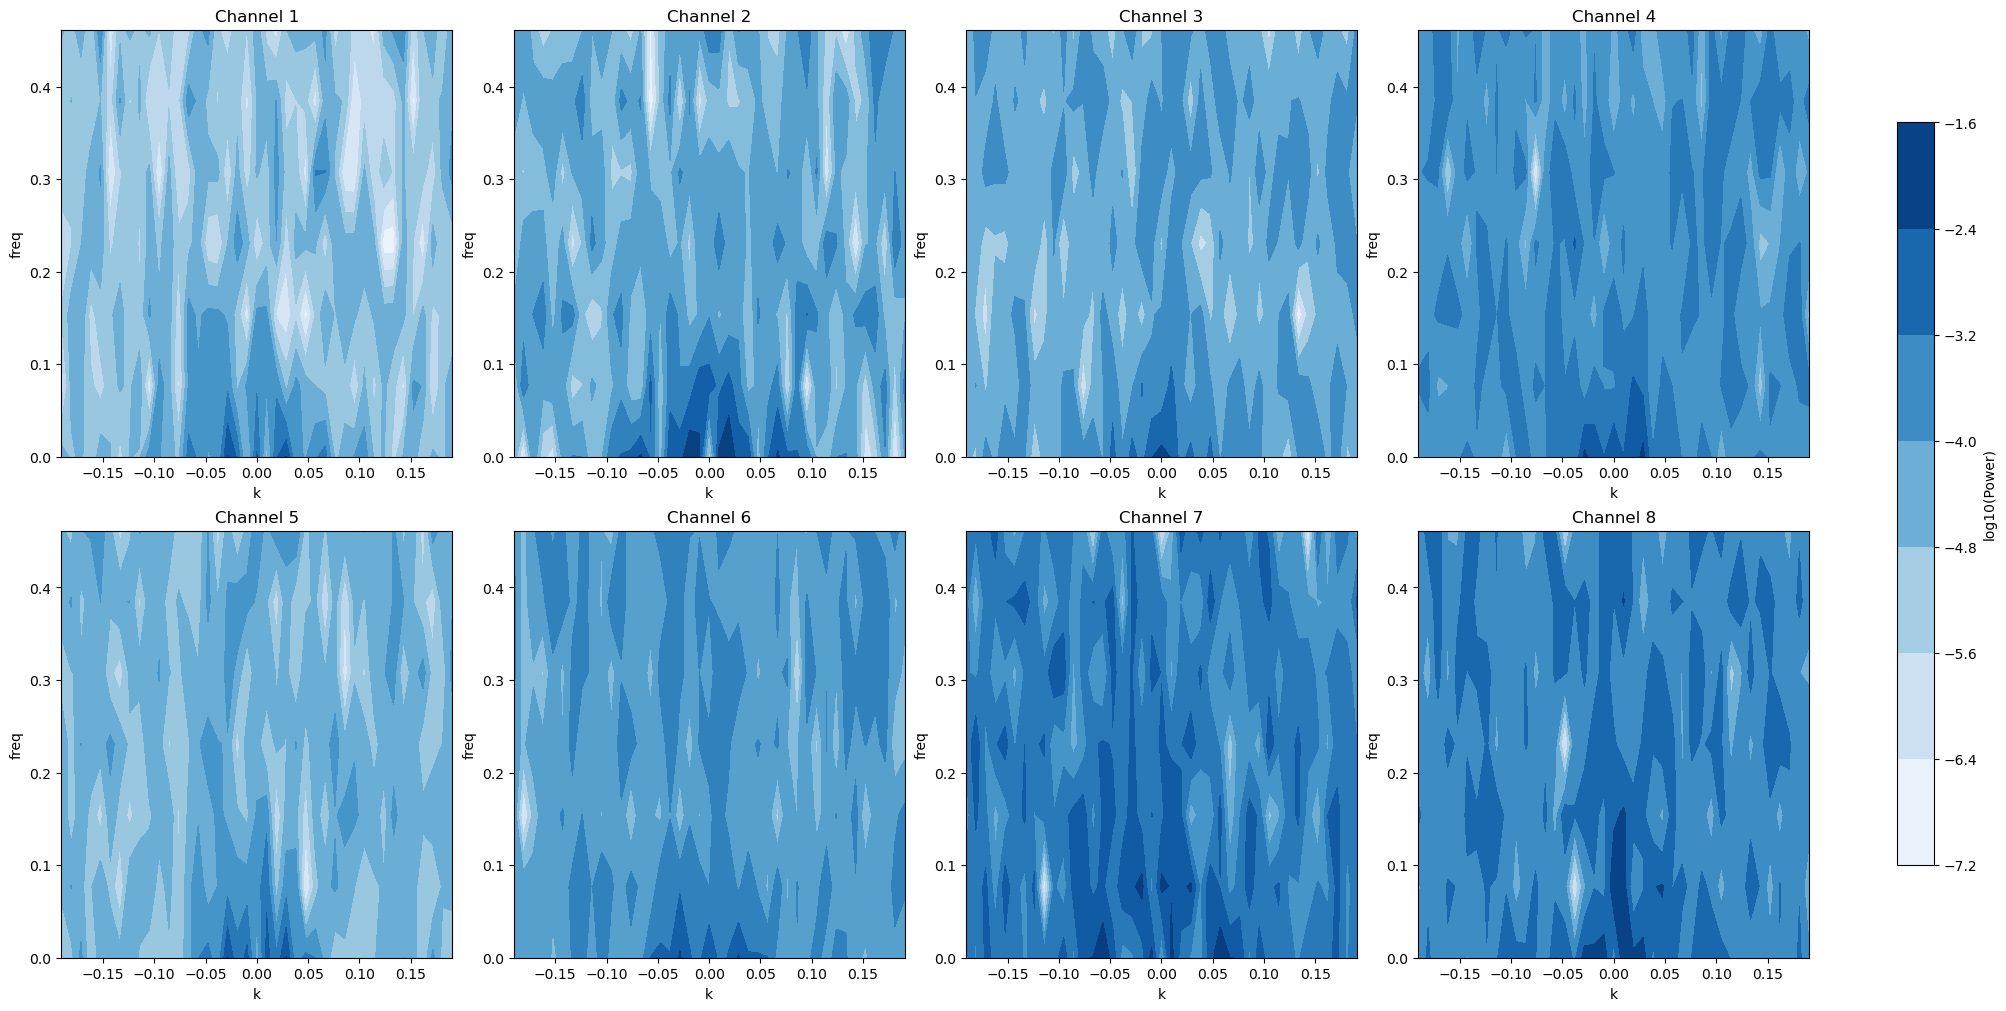

In [6]:
x = np.concatenate([power.kx[-20:], power.kx[:21]], axis=0)
y = power.ky[:7]
fig, axes = plt.subplots(2, 4, figsize=(20, 10), constrained_layout=True)

for i in range(8):
    ax = axes[i // 4, i % 4]
    data = np.concatenate([np.log10(power[0,i,:,:].squeeze())[:7, -20:], np.log10(power[0,i,:,:].squeeze())[:7, :21]], axis=1)  # select first 20 k values
    cf = ax.contourf(x, y, data, cmap='Blues')
    ax.set_title(f'Channel {i+1}')
    ax.set_xlabel('k')
    ax.set_ylabel('freq')

# Add a single colorbar for all subplots
fig.colorbar(cf, ax=axes, orientation='vertical', shrink=0.8, label='log10(Power)')

plt.show()